In [1]:
# %matplotlib inline

In [2]:
import time
import os
import copy

import numpy as np
import pandas as pd
import PIL
import random
import seaborn as sn
import torchvision as tv
import torch
from data_cleaning import data_cleaning
from data_loader import PyTorchDataLoader, img_stat
from matplotlib import pyplot as plt
from torch.optim import lr_scheduler
from torch import nn
from torch import optim

plt.ion() 

In [3]:
data_cleaning(moeimouto=False, self_collected=True, force_write=True)


[STATUS] copying pics in data_set/self-collected/003_0_mato_sakura_official to data_set/modeling_data/mato_sakura
[STATUS] 003_0_mato_sakura_official copy work finished
[STATUS] copying pics in data_set/self-collected/004_0_illyasviel_von_einzbern_official to data_set/modeling_data/illyasviel_von_einzbern
[STATUS] 004_0_illyasviel_von_einzbern_official copy work finished
[STATUS] copying pics in data_set/self-collected/006_0_misaka_mikoto_official to data_set/modeling_data/misaka_mikoto
[STATUS] 006_0_misaka_mikoto_official copy work finished
[STATUS] copying pics in data_set/self-collected/005_0_rider_medusa_official to data_set/modeling_data/rider_medusa
[STATUS] 005_0_rider_medusa_official copy work finished
[STATUS] copying pics in data_set/self-collected/007_0_violet_evergarden_official to data_set/modeling_data/violet_evergarden
[STATUS] 007_0_violet_evergarden_official copy work finished
[STATUS] copying pics in data_set/self-collected/002_0_tohsaka_rin_official to data_set/mode

In [4]:
# mean = [0.485, 0.456, 0.406]
# std = [0.229, 0.224, 0.225]
mean = [0.6529833,  0.56954163, 0.55970765] # calculated using data_loader.img_stat() on the whole dataset
std = [0.29683845, 0.29733288, 0.28085221]
pic_size = (224,224) # as requested when using pretrained model in torchvision
loader_gen = PyTorchDataLoader(pic_size=pic_size, channel_mean=mean, channel_std=std)
img_transform = tv.transforms.Compose([
                tv.transforms.RandomResizedCrop(pic_size),
                tv.transforms.RandomHorizontalFlip(),
                tv.transforms.ToTensor(),
                tv.transforms.Normalize(mean, std)
            ])
dataloaders, dataset_sizes, character_names, img_transform = loader_gen.load_image(data_transforms=img_transform, batch_size=8)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: {}".format(device))

Character names: ['illyasviel_von_einzbern', 'mato_sakura', 'misaka_mikoto', 'rider_medusa', 'saber_arutoria_pendoragon', 'tohsaka_rin', 'violet_evergarden']
Using device: cuda:0


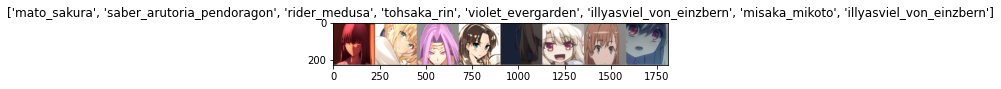

In [5]:
inputs, classes = next(iter(dataloaders['train']))
out = tv.utils.make_grid(inputs)

loader_gen.loader_display(out, title=[character_names[x] for x in classes])

In [6]:
def train_model(model, model_name, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('{} Epoch {}/{}'.format(model_name or "", epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'
                  .format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training {} complete in {:.0f}m {:.0f}s'
          .format(model_name or "", time_elapsed // 60, time_elapsed % 60))
    print('{} Best val Acc: {:4f}'.format(model_name, best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
models = {
    'rn18' : tv.models.resnet18(pretrained=True),
    'rn34' : tv.models.resnet34(pretrained=True),
    'rn50' : tv.models.resnet50(pretrained=True),
    'rn101' : tv.models.resnet101(pretrained=True),
}

for key in models.keys():
    model = models[key]
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(character_names))
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
    print("[STATUS] start training model: {}".format(key))
    model = train_model(model, key, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

[STATUS] start training model: rn18
rn18 Epoch 0/24
----------
train Loss: 1.1783 Acc: 0.6187
test Loss: 0.4220 Acc: 0.8616

rn18 Epoch 1/24
----------
train Loss: 0.4578 Acc: 0.8623
test Loss: 0.3039 Acc: 0.9119

rn18 Epoch 2/24
----------
train Loss: 0.3261 Acc: 0.9066
test Loss: 0.1945 Acc: 0.9308

rn18 Epoch 3/24
----------
train Loss: 0.3196 Acc: 0.8956
test Loss: 0.1954 Acc: 0.9434

rn18 Epoch 4/24
----------
train Loss: 0.2441 Acc: 0.9256
test Loss: 0.1711 Acc: 0.9434

rn18 Epoch 5/24
----------
train Loss: 0.2097 Acc: 0.9367
test Loss: 0.2536 Acc: 0.9245

rn18 Epoch 6/24
----------
train Loss: 0.2242 Acc: 0.9288
test Loss: 0.2246 Acc: 0.9245

rn18 Epoch 7/24
----------
train Loss: 0.1392 Acc: 0.9589
test Loss: 0.1489 Acc: 0.9560

rn18 Epoch 8/24
----------
train Loss: 0.1262 Acc: 0.9636
test Loss: 0.1204 Acc: 0.9623

rn18 Epoch 9/24
----------
train Loss: 0.1562 Acc: 0.9478
test Loss: 0.1122 Acc: 0.9686

rn18 Epoch 10/24
----------
train Loss: 0.1314 Acc: 0.9589
test Loss: 0.16

train Loss: 0.1189 Acc: 0.9684
test Loss: 0.0935 Acc: 0.9623

rn101 Epoch 14/24
----------
train Loss: 0.1308 Acc: 0.9573
test Loss: 0.0990 Acc: 0.9623

rn101 Epoch 15/24
----------
train Loss: 0.1323 Acc: 0.9620
test Loss: 0.0691 Acc: 0.9686

rn101 Epoch 16/24
----------
train Loss: 0.0776 Acc: 0.9826
test Loss: 0.0481 Acc: 0.9874

rn101 Epoch 17/24
----------
train Loss: 0.1265 Acc: 0.9604
test Loss: 0.0809 Acc: 0.9686

rn101 Epoch 18/24
----------
train Loss: 0.0868 Acc: 0.9731
test Loss: 0.0741 Acc: 0.9686

rn101 Epoch 19/24
----------
train Loss: 0.1080 Acc: 0.9699
test Loss: 0.1069 Acc: 0.9560

rn101 Epoch 20/24
----------
train Loss: 0.1042 Acc: 0.9699
test Loss: 0.0856 Acc: 0.9748

rn101 Epoch 21/24
----------
train Loss: 0.1206 Acc: 0.9652
test Loss: 0.1164 Acc: 0.9560

rn101 Epoch 22/24
----------
train Loss: 0.1105 Acc: 0.9668
test Loss: 0.0771 Acc: 0.9748

rn101 Epoch 23/24
----------
train Loss: 0.1213 Acc: 0.9699
test Loss: 0.1198 Acc: 0.9686

rn101 Epoch 24/24
----------

In [8]:
def random_visualization(model, model_name=None):
    model.eval()
    modeling_data_path = os.path.join('data_set', 'modeling_data')
    characters_folders = os.listdir(modeling_data_path)
    for character in characters_folders:
        pic_folder = os.path.join(modeling_data_path, character)
        all_pics = os.listdir(pic_folder)
        sampling = random.choices(all_pics, k=1)
        for pic in sampling:
            pic_dir = os.path.join(pic_folder, pic)
            raw_img = PIL.Image.open(pic_dir).convert('RGB')
            img = img_transform(raw_img).float()
            img = torch.autograd.Variable(img, requires_grad=True)
            img = img.unsqueeze(0).cuda()
            outputs = model(img)
            _, preds = torch.max(outputs, 1)
            pred_result = character_names[preds[0]]
            plt.imshow(raw_img)
            plt.title("{} Prediction: {}, Truth: {}, Corret: {}"
                      .format(model_name or "", pred_result, character, pred_result == character))
            plt.show()

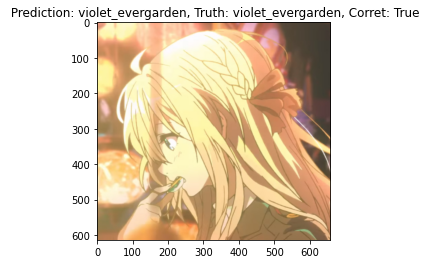

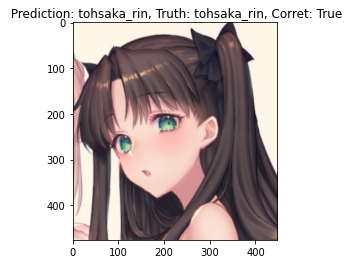

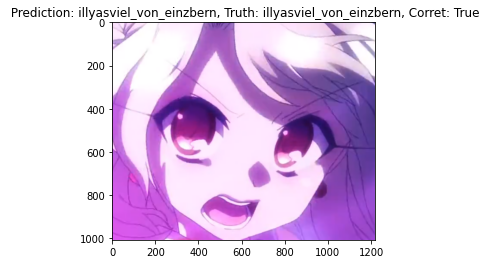

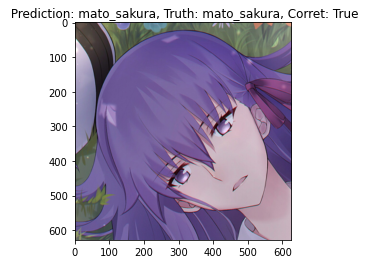

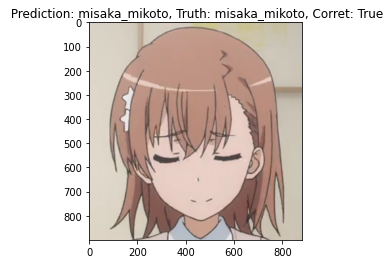

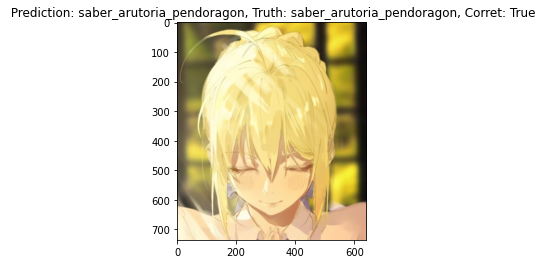

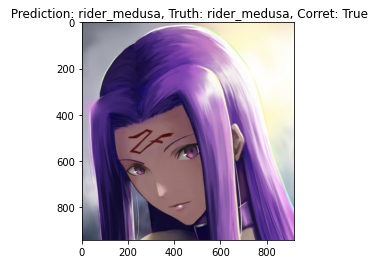

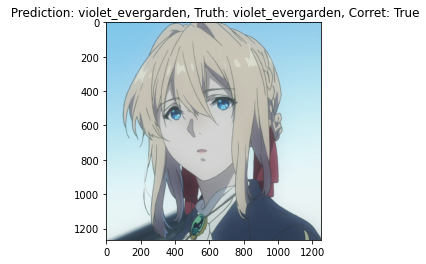

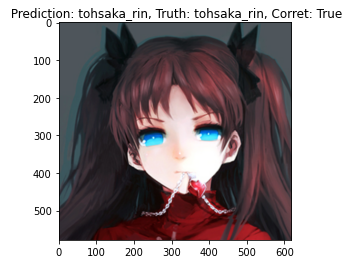

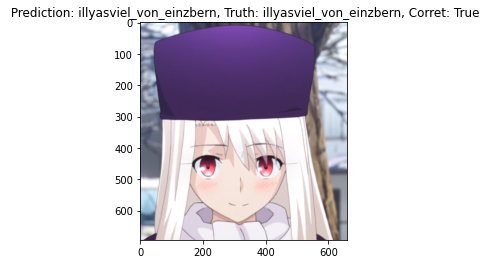

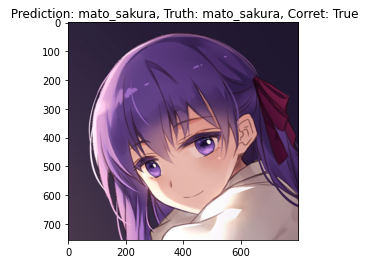

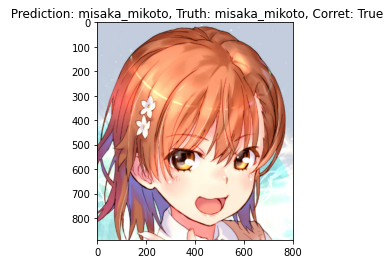

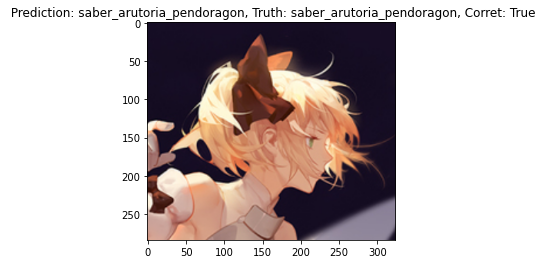

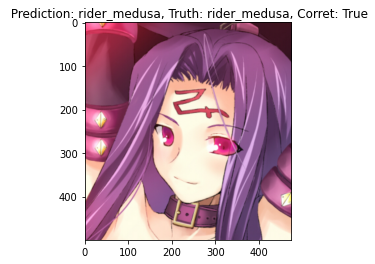

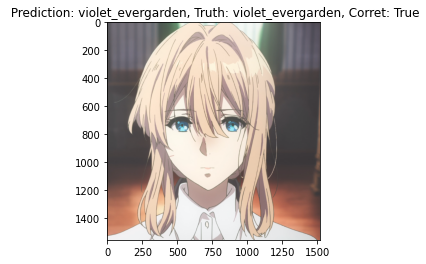

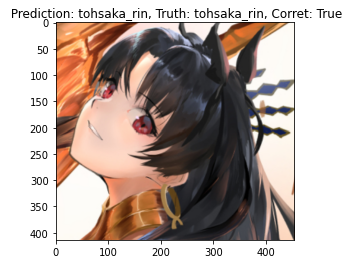

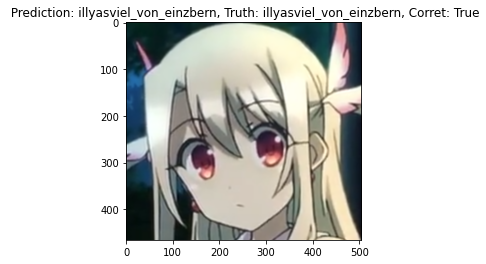

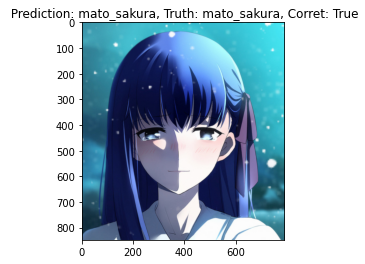

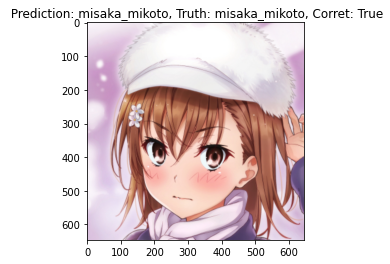

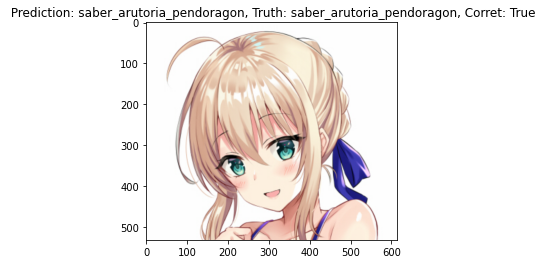

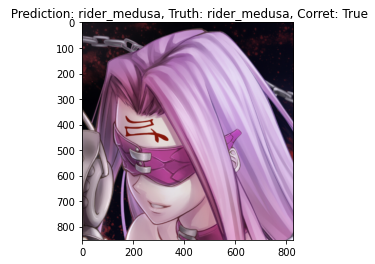

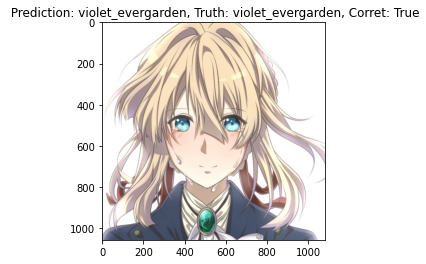

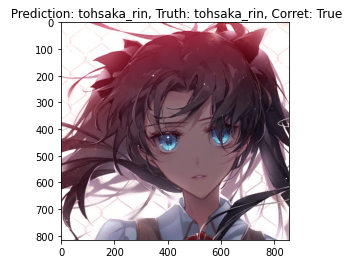

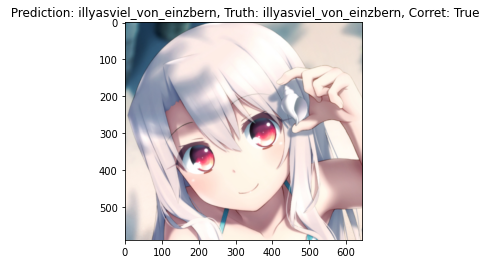

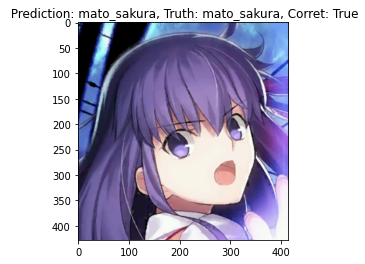

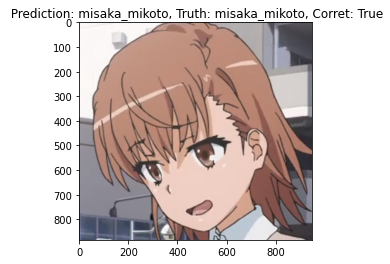

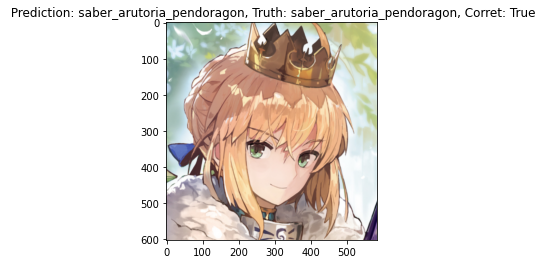

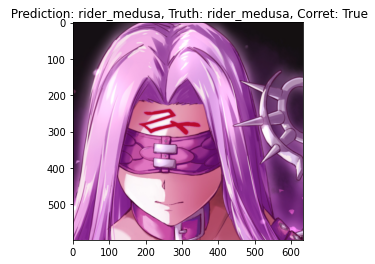

In [9]:
for key in models.keys():
    random_visualization(models[key])

In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(character_names[preds[j]]))
                loader_gen.loader_display(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

model name: rn18


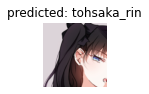

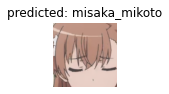

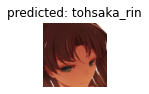

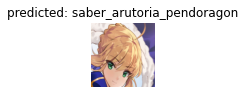

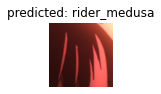

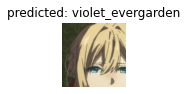

model name: rn34


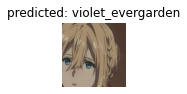

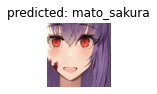

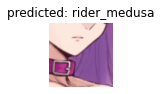

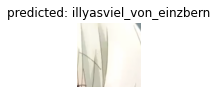

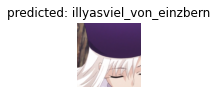

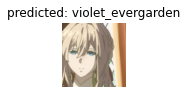

model name: rn50


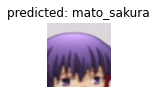

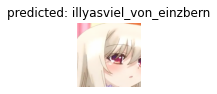

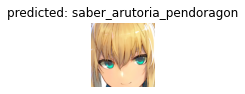

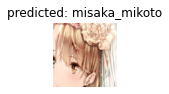

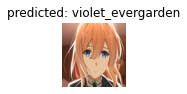

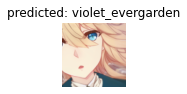

model name: rn101


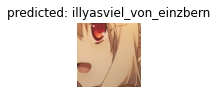

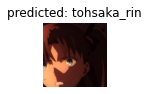

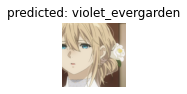

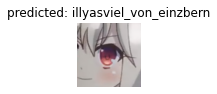

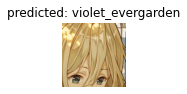

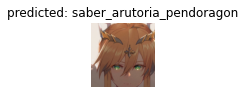

In [11]:
for key in models.keys():
    print("model name: {}".format(key))
    visualize_model(models[key])

In [12]:
def confusion_matrix(model, n_class, normalize=True):
    model.eval()
    confusion_matrix = torch.zeros(n_class, n_class)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
    confusion_matrix = confusion_matrix.numpy()
    if normalize:
        confusion_matrix = confusion_matrix/confusion_matrix.sum(axis=1)
    return confusion_matrix

def plot_cm(cm, class_label, title="Confusion Matrix"):
    df_cm = pd.DataFrame(cm, class_label, class_label)
    # plt.figure(figsize=(10,7))
    sn.set(font_scale=1.4) # for label size
    chart = sn.heatmap(df_cm, cmap=plt.cm.Blues, annot=True, annot_kws={"size": 12})
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90, horizontalalignment='center')
    plt.title(title)
    plt.show()

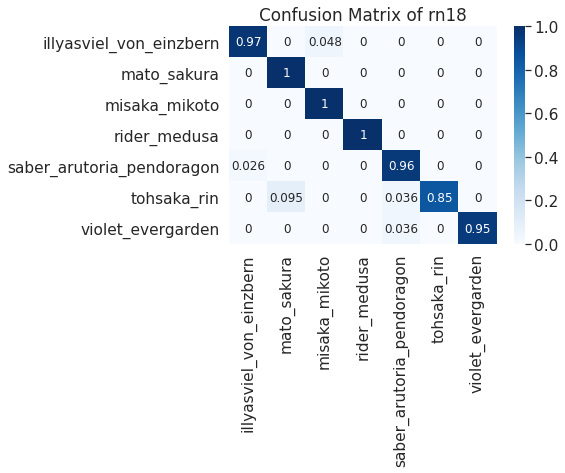

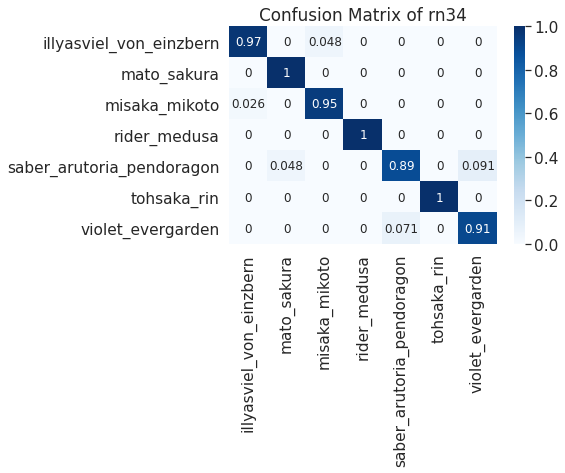

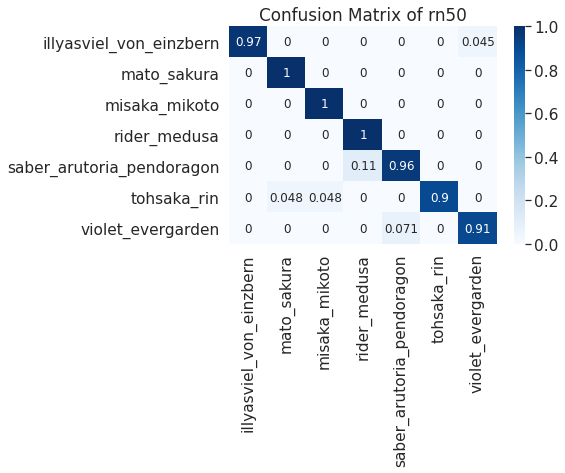

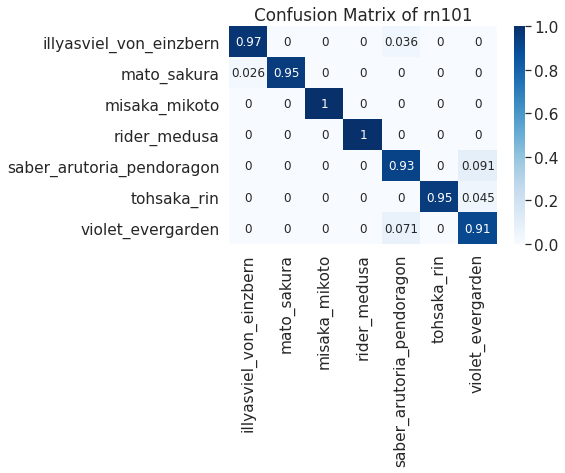

In [13]:
for key in models.keys():
    model = models[key]
    cm = confusion_matrix(model, len(character_names))
    plot_cm(cm, character_names, "Confusion Matrix of {}".format(key))

[STATUS] Destination folder data_set/testing_data already exist, do nothing
[STATUS] Extract img color mean and std milfeulle_sakuraba
[STATUS] Extract img color mean and std seto_san
[STATUS] Extract img color mean and std reinforce_zwei
[STATUS] Extract img color mean and std asakura_yume
[STATUS] Extract img color mean and std flandre_scarlet
[STATUS] Extract img color mean and std kallen_stadtfeld
[STATUS] Extract img color mean and std fuyou_kaede
[STATUS] Extract img color mean and std fujibayashi_kyou
[STATUS] Extract img color mean and std kobayakawa_yutaka
[STATUS] Extract img color mean and std kanu
[STATUS] Extract img color mean and std maka_albarn
[STATUS] Extract img color mean and std sairenji_haruna
[STATUS] Extract img color mean and std belldandy
[STATUS] Extract img color mean and std caro_ru_lushe
[STATUS] Extract img color mean and std hiiragi_kagami
[STATUS] Extract img color mean and std nagato_yuki
[STATUS] Extract img color mean and std ichinose_kotomi
[STATUS]

[STATUS] Extract img color mean and std kotegawa_yui
[STATUS] Extract img color mean and std c.c
[STATUS] Extract img color mean and std ibuki_fuuko
[STATUS] Extract img color mean and std daidouji_tomoyo
[STATUS] Extract img color mean and std yuno
[STATUS] Extract img color mean and std ito_chika
[STATUS] Extract img color mean and std hiiragi_tsukasa
[STATUS] Extract img color mean and std houjou_reika
[STATUS] Extract img color mean and std miyafuji_yoshika
Character names: ['aika_granzchesta', 'aisaka_taiga', 'akihime_sumomo', 'akiyama_mio', 'akizuki_ritsuko', 'alice_margatroid', 'amami_haruka', 'ana_coppola', 'andou_mahoro', 'arcueid_brunestud', 'asagiri_mai', 'asahina_mikuru', 'asakura_otome', 'asakura_yume', 'ayanami_rei', 'ayasaki_hayate', 'belldandy', 'black_rock_shooter', 'c.c', 'canal_volphied', 'caro_ru_lushe', 'chii', 'cirno', 'corticarte_apa_lagranges', 'daidouji_tomoyo', 'enma_ai', 'fate_testarossa', 'feena_fam_earthlight', 'flandre_scarlet', 'fujibayashi_kyou', 'fukuza

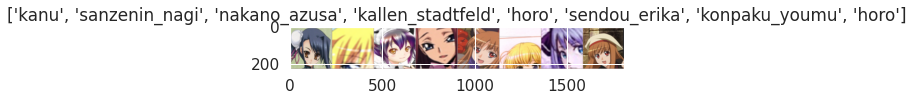

In [27]:
data_cleaning(moeimouto=True, self_collected=True, destination="testing_data", force_write=False)

mean, std = img_stat("data_set/testing_data")
pic_size = (224,224)

loader_gen = PyTorchDataLoader(data_dir="data_set/testing_data", pic_size=pic_size,
                               channel_mean=mean, channel_std=std)
img_transform = tv.transforms.Compose([
                tv.transforms.RandomResizedCrop(pic_size),
                tv.transforms.RandomHorizontalFlip(),
                tv.transforms.ToTensor(),
                tv.transforms.Normalize(mean, std)
            ])
dataloaders, dataset_sizes, character_names, img_transform = loader_gen.load_image(data_transforms=img_transform, batch_size=8)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: {}".format(device))

inputs, classes = next(iter(dataloaders['train']))
out = tv.utils.make_grid(inputs)

loader_gen.loader_display(out, title=[character_names[x] for x in classes])


In [14]:
best_model = tv.models.resnet50(pretrained=True)

num_ftrs = best_model.fc.in_features
best_model.fc = nn.Linear(num_ftrs, len(character_names))
best_model = best_model.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(best_model.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
print("[STATUS] start training model: ResNet50")
best_model = train_model(best_model, "ResNet50", criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)


[STATUS] start training model: ResNet50
ResNet50 Epoch 0/24
----------
train Loss: 3.3237 Acc: 0.2766
test Loss: 1.5845 Acc: 0.5714

ResNet50 Epoch 1/24
----------
train Loss: 1.5479 Acc: 0.6243
test Loss: 0.8713 Acc: 0.7692

ResNet50 Epoch 2/24
----------
train Loss: 1.0541 Acc: 0.7336
test Loss: 0.6529 Acc: 0.8239

ResNet50 Epoch 3/24
----------
train Loss: 0.8368 Acc: 0.7889
test Loss: 0.6613 Acc: 0.8243

ResNet50 Epoch 4/24
----------
train Loss: 0.7160 Acc: 0.8162
test Loss: 0.5486 Acc: 0.8576

ResNet50 Epoch 5/24
----------
train Loss: 0.6568 Acc: 0.8309
test Loss: 0.5913 Acc: 0.8435

ResNet50 Epoch 6/24
----------
train Loss: 0.5859 Acc: 0.8476
test Loss: 0.5193 Acc: 0.8645

ResNet50 Epoch 7/24
----------
train Loss: 0.4455 Acc: 0.8947
test Loss: 0.4176 Acc: 0.8866

ResNet50 Epoch 8/24
----------
train Loss: 0.3973 Acc: 0.9061
test Loss: 0.4104 Acc: 0.8913

ResNet50 Epoch 9/24
----------
train Loss: 0.3623 Acc: 0.9106
test Loss: 0.3770 Acc: 0.9014

ResNet50 Epoch 10/24
---------

In [28]:
models = {
    'rn18' : tv.models.resnet18(pretrained=True),
    'rn34' : tv.models.resnet34(pretrained=True),
    'rn50' : tv.models.resnet50(pretrained=True),
    'rn101' : tv.models.resnet101(pretrained=True),
}

for key in models.keys():
    model = models[key]
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(character_names))
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
    print("[STATUS] start training model: {}".format(key))
    model = train_model(model, key, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

[STATUS] start training model: rn18
rn18 Epoch 0/24
----------
train Loss: 3.2467 Acc: 0.2978
test Loss: 1.5233 Acc: 0.6051

rn18 Epoch 1/24
----------
train Loss: 1.5829 Acc: 0.6206
test Loss: 0.9725 Acc: 0.7478

rn18 Epoch 2/24
----------
train Loss: 1.1302 Acc: 0.7310
test Loss: 0.8214 Acc: 0.7837

rn18 Epoch 3/24
----------
train Loss: 0.9480 Acc: 0.7656
test Loss: 0.7673 Acc: 0.8040

rn18 Epoch 4/24
----------
train Loss: 0.8159 Acc: 0.7924
test Loss: 0.6509 Acc: 0.8275

rn18 Epoch 5/24
----------
train Loss: 0.7178 Acc: 0.8147
test Loss: 0.6494 Acc: 0.8315

rn18 Epoch 6/24
----------
train Loss: 0.6668 Acc: 0.8305
test Loss: 0.6244 Acc: 0.8380

rn18 Epoch 7/24
----------
train Loss: 0.5491 Acc: 0.8641
test Loss: 0.5032 Acc: 0.8634

rn18 Epoch 8/24
----------
train Loss: 0.4859 Acc: 0.8847
test Loss: 0.5209 Acc: 0.8685

rn18 Epoch 9/24
----------
train Loss: 0.4720 Acc: 0.8851
test Loss: 0.4896 Acc: 0.8714

rn18 Epoch 10/24
----------
train Loss: 0.4776 Acc: 0.8836
test Loss: 0.49

test Loss: 0.3672 Acc: 0.9043

rn101 Epoch 13/24
----------
train Loss: 0.2743 Acc: 0.9308
test Loss: 0.3627 Acc: 0.9058

rn101 Epoch 14/24
----------
train Loss: 0.2729 Acc: 0.9339
test Loss: 0.3671 Acc: 0.9112

rn101 Epoch 15/24
----------
train Loss: 0.2655 Acc: 0.9369
test Loss: 0.3521 Acc: 0.9083

rn101 Epoch 16/24
----------
train Loss: 0.2767 Acc: 0.9328
test Loss: 0.3844 Acc: 0.9069

rn101 Epoch 17/24
----------
train Loss: 0.2672 Acc: 0.9339
test Loss: 0.3644 Acc: 0.9043

rn101 Epoch 18/24
----------
train Loss: 0.2590 Acc: 0.9370
test Loss: 0.3771 Acc: 0.9054

rn101 Epoch 19/24
----------
train Loss: 0.2632 Acc: 0.9379
test Loss: 0.3815 Acc: 0.8996

rn101 Epoch 20/24
----------
train Loss: 0.2564 Acc: 0.9371
test Loss: 0.3784 Acc: 0.9007

rn101 Epoch 21/24
----------
train Loss: 0.2635 Acc: 0.9360
test Loss: 0.3361 Acc: 0.9163

rn101 Epoch 22/24
----------
train Loss: 0.2729 Acc: 0.9366
test Loss: 0.3668 Acc: 0.9014

rn101 Epoch 23/24
----------
train Loss: 0.2707 Acc: 0.9335